# TFT for Multivariate Time Series Prediction

본 프로젝트는 TFT 개념을 발제한 아래의 논문을 기반으로 합니다.
Time Series Data에 대한 분석에서 SOTA 알고리즘인 TFT 논문을 꼭 읽어보시길 추천드립니다!

[Lim et al.(2019), Temporal Fusion Transformers
for Interpretable Multi-horizon Time Series Forecasting](https://arxiv.org/pdf/1912.09363.pdf)

Reference :
- [pytorch-forecasting](https://github.com/jdb78/pytorch-forecasting)
- https://bigwaveai.tistory.com/5

In [1]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

In [2]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# Load Data

사용 데이터 : [Stallion Kaggle Competition Dataset](https://www.kaggle.com/utathya/future-volume-prediction)

프로젝트를 위해서 캐글 stallion 데이터를 사용합니다.
Industry-Volume을 기반으로 Sales를 예측하기 위한 데이터셋입니다.

In [3]:
from pytorch_forecasting.data.examples import get_stallion_data

data = get_stallion_data()
data

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,...,labor_day,independence_day,revolution_day_memorial,regional_games,fifa_u_17_world_cup,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries
0,Agency_22,SKU_01,52.2720,2013-01-01,492612703,718394219,25.845238,1168.903668,1069.166193,99.737475,...,0,0,0,0,0,0,0,0,8.532566,0
238,Agency_37,SKU_04,0.0000,2013-01-01,492612703,718394219,26.505000,1852.273642,1611.466298,240.807344,...,0,0,0,0,0,0,0,0,13.000635,5
237,Agency_59,SKU_03,812.9214,2013-01-01,492612703,718394219,22.219737,1270.795012,1197.184260,73.610752,...,0,0,0,0,0,0,0,0,5.792496,9
236,Agency_11,SKU_01,316.4400,2013-01-01,492612703,718394219,25.360000,1176.155397,1082.757488,93.397909,...,0,0,0,0,0,0,0,0,7.940950,14
235,Agency_05,SKU_05,420.9093,2013-01-01,492612703,718394219,24.079012,1327.003396,1207.822992,119.180404,...,0,0,0,0,0,0,0,0,8.981168,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6765,Agency_08,SKU_03,9.8136,2017-12-01,618073219,919709619,25.373665,1706.410263,1455.262060,251.148203,...,0,0,0,0,0,0,0,0,14.717926,336
6764,Agency_60,SKU_05,2235.3495,2017-12-01,618073219,919709619,23.081069,1898.981558,1528.616113,370.365445,...,0,0,0,0,0,0,0,0,19.503372,188
6763,Agency_19,SKU_05,87.5430,2017-12-01,618073219,919709619,27.432590,1902.160687,1547.299733,354.860954,...,0,0,0,0,0,0,0,0,18.655677,162
6771,Agency_60,SKU_03,325.8792,2017-12-01,618073219,919709619,23.081069,1704.503815,1444.443913,260.059902,...,0,0,0,0,0,0,0,0,15.257220,187


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21000 entries, 0 to 6650
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   agency                            21000 non-null  category      
 1   sku                               21000 non-null  category      
 2   volume                            21000 non-null  float64       
 3   date                              21000 non-null  datetime64[ns]
 4   industry_volume                   21000 non-null  int64         
 5   soda_volume                       21000 non-null  int64         
 6   avg_max_temp                      21000 non-null  float64       
 7   price_regular                     21000 non-null  float64       
 8   price_actual                      21000 non-null  float64       
 9   discount                          21000 non-null  float64       
 10  avg_population_2017               21000 non-nul

기존 시계열 분석 기법은 예측 시간 간격이 길어질수록 목표값의 예측이 어렵다는 문제점이 있었습니다. 이는 예측 모델이 가지고 있을 미래의 어떤 정보도 활용하지 못한 채 긴 시퀀스를 예측해야하기 때문이었습니다.

**만약 바로 다음 time step 시점의 목표값을 예측한다면** 바로 전 시점 데이터를 활용할 수 있기에 비교적 쉬운 task가 됩니다.

본 논문에서는 이 점을 지적하면서 미래 시점에 미리 알 수 있는 정보들을 활용할 수 있도록 딥러닝 모델을 구성하였습니다. 한주의 요일, 월, 휴일, 미리 계획된 사항 등에 관련된 변수들은 미래에도 알 수 있는 변수들입니다. 이를 장기적인 시간 정보를 가지고 있는 데이터를 분석할 때 활용할 수 있다면 time step이 길어지더라도 우수한 성능으로 예측할 수 있습니다.

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdlqwQd%2Fbtq0SlXgNy1%2FB7mwiQRtrPWZxngI94dQQ0%2Fimg.png)

따라서 가지고 있는 데이터를 바탕으로 미래에 알 수 있는 변수들을 생성해야 합니다.
date를 통해 'month'를, 이미 지정한 Special Day들을 바탕으로 'special_days' column을 생성합니다.

In [5]:
# add time index
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min()

# add additional features
data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")

# we want to encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]
data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
data.sample(10, random_state=521)

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,...,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
291,Agency_25,SKU_03,0.5076,2013-01-01,492612703,718394219,25.845238,1264.162234,1152.473405,111.688829,...,-,-,-,8.835008,228,0,1,-0.678062,1225.306376,99.650400
871,Agency_29,SKU_02,8.7480,2015-01-01,498567142,762225057,27.584615,1316.098485,1296.804924,19.293561,...,-,-,-,1.465966,177,24,1,2.168825,1634.434615,11.397086
19532,Agency_47,SKU_01,4.9680,2013-09-01,454252482,789624076,30.665957,1269.250000,1266.490490,2.759510,...,-,-,-,0.217413,322,8,9,1.603017,2625.472644,48.295650
2089,Agency_53,SKU_07,21.6825,2013-10-01,480693900,791658684,29.197727,1193.842373,1128.124395,65.717978,...,-,beer_capital,-,5.504745,240,9,10,3.076505,38.529107,2511.035175
9755,Agency_17,SKU_02,960.5520,2015-03-01,515468092,871204688,23.608120,1338.334248,1232.128069,106.206179,...,-,-,music_fest,7.935699,259,26,3,6.867508,2143.677462,396.022140
7561,Agency_05,SKU_03,1184.6535,2014-02-01,425528909,734443953,28.668254,1369.556376,1161.135214,208.421162,...,-,-,-,15.218151,21,13,2,7.077206,1566.643589,1881.866367
19204,Agency_11,SKU_05,5.5593,2017-08-01,623319783,1049868815,31.915385,1922.486644,1651.307674,271.178970,...,-,-,-,14.105636,17,55,8,1.715472,1385.225478,109.699200
8781,Agency_48,SKU_04,4275.1605,2013-03-01,509281531,892192092,26.767857,1761.258209,1546.059670,215.198539,...,-,-,music_fest,12.218455,151,2,3,8.360577,1757.950603,1925.272108
2540,Agency_07,SKU_21,0.0000,2015-10-01,544203593,761469815,28.987755,0.000000,0.000000,0.000000,...,-,-,-,0.000000,300,33,10,-18.420681,0.000000,2418.719550
12084,Agency_21,SKU_03,46.3608,2017-04-01,589969396,940912941,32.478910,1675.922116,1413.571789,262.350327,...,-,-,-,15.654088,181,51,4,3.836454,2034.293024,109.381800


In [6]:
data.describe()

,volume,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,discount_in_percent,timeseries,time_idx,log_volume,avg_volume_by_sku,avg_volume_by_agency
count,21000.000000,2.100000e+04,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.00000,21000.000000,21000.000000,21000.000000,21000.000000
mean,1492.403982,5.439214e+08,8.512000e+08,28.612404,1451.536344,1267.347450,184.374146,1.045065e+06,151073.494286,10.574884,174.50000,29.500000,2.464118,1492.403982,1492.403982
std,2711.496882,6.288022e+07,7.824340e+07,3.972833,683.362417,587.757323,257.469968,9.291926e+05,50409.593114,9.590813,101.03829,17.318515,8.178218,1051.790829,1328.239698
min,0.000000,4.130518e+08,6.964015e+08,16.731034,0.000000,-3121.690141,0.000000,1.227100e+04,90240.000000,0.000000,0.00000,0.000000,-18.420681,0.000000,0.000000
25%,8.272388,5.090553e+08,7.890880e+08,25.374816,1311.547158,1178.365653,54.935108,6.018900e+04,110057.000000,3.749628,87.00000,14.750000,2.112923,932.285496,113.420250
50%,158.436000,5.512000e+08,8.649196e+08,28.479272,1495.174592,1324.695705,138.307225,1.232242e+06,131411.000000,8.948990,174.50000,29.500000,5.065351,1402.305264,1730.529771
75%,1774.793475,5.893715e+08,9.005551e+08,31.568405,1725.652080,1517.311427,272.298630,1.729177e+06,206553.000000,15.647058,262.00000,44.250000,7.481439,2195.362302,2595.316500
max,22526.610000,6.700157e+08,1.049869e+09,45.290476,19166.625000,4925.404000,19166.625000,3.137874e+06,247220.000000,226.740147,349.00000,59.000000,10.022453,4332.363750,5884.717375


# Create Dataset and Dataloaders

다음으로 dataframe을 pytorch-forecasting에서 제공하는 TimeSeriesDataset으로 변환하여야 합니다. 데이터셋은 Categorical 변수와 Continuous 변수를 모두 가지고 있으며 그것들은 각각 static하거나 시간에 따라 varying하는 특징도 가지고 있기에 변수들을 적절하게 넣어주어야 합니다.

- **예측하고자 하는 타겟 변수** : "volume"
- **정적 카테고리 변수** : "agency", "sku"
- **정적 실수 변수** : "avg_population_2017", "avg_yearly_household_income_2017"
- **미래 데이터이지만 현재 알 수 있는 변수** : "special_days", "month"
- **시간에 따라 변하는 시계열 데이터** : "volume","log_volume","industry_volume", "soda_volume", "avg_max_temp", "avg_volume_by_agency", "avg_volume_by_sku"
        
위와 같이 변수들을 parameter에 적절하게 넣어주어야 합니다.

In [7]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    group_ids=["agency", "sku"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["agency", "sku"],
    static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["special_days", "month"],
    variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],
    target_normalizer=GroupNormalizer(
        groups=["agency", "sku"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

# Create Baseline Model

단순히 마지막으로 관찰된 Volume을 반복하여 다음 6개월을 예측하는 Baseline 모델을 Evaluate하면 우리가 Outperform하고자 하는 간단한 Benchmark를 얻을 수 있습니다.

In [8]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

293.0088195800781

# Train TFT Model

In [9]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)

Global seed set to 42
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


# Model Architecture

우선 시계열 데이터 중 관측 변수는 과거 시점의 LSTM 인코더에 입력됩니다.
Time_Varying_Known 변수는 과거 시점과 함께 미래 시점의 LSTM 디코더에 같이 입력됩니다.
Static_Variable은 고정되어 있는 변수이기 때문에 변수 선정 네트워크, LSTM 인코더, GRN을 통해 충분한 정보를 전체 레이어에 전달합니다.
모든 변수는 선정 네트워크 과정을 거치며 매 시점마다 평가되어 중요한 변수만 모델에 입력됩니다.

이후 일련의 과정을 거친 입력 정보들은 Masked Interpretable Multi-Head Attention Layer에 전달됩니다. Attention Layer에서 산출된 정보는 Position Wise Feed Forward Non-linear Layer, GRN을 거쳐 입력됩니다. 최종 출력값은 LSTM 디코더의 출력 정보를 반영하여 모델의 복잡성을 완화합니다. 전반적으로 게이팅 매커니즘을 통해 네트워크의 복잡성 문제를 해결합니다.

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FlXt48%2Fbtq0LPFDF4W%2FGmguyQ8bwe1EfB3tri7dx1%2Fimg.png)

- **Gating Mechanisms** : 모델 학습 시 과거 데이터 중 불필요한 시점의 입력을 통제
- **Variable Selection Networks** : 각 time steps 마다 적절한 입력 변수 선정
- **Static Covariate Encoders** : 정적 공변량을 모델에 입력할 수 있는 형태로 통합하여 Context Vector로써 동적 변수의 조건으로 설정
- **Temporal Processing** : 관측값 및 미래에 알 수 있는 값을 LSTM에 입력하기 위한 시점 처리, Interpretable Multi-head Attention 기법의 적용
- **Prediction Intervals** : 각 예측 시점마다 목표 변수의 범위를 결정하기 위한 분위수 예측

In [10]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.067608,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).


Number of parameters in network: 29.7k


훈련 속도는 여기에서 주로 Overhead에 의해 결정되며 더 큰 batch_size 또는 hidden_size를 선택하면 훈련이 선형적으로 느려지지 않아 더 큰 데이터에 대한 빠른 훈련이 가능합니다.

이번 프로젝트에서는 batch_size이자 Hidden_size를 16으로 설정하여 훈련 속도를 조절하였습니다.

/home/junghwan/anaconda3/envs/pytorch1/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K 
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.4 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.0 K 
6  | decoder_variable

Epoch 0:  50%|▌| 1/2 [00:00<00:00,  2.02it/s, loss=143, v_num=, train_loss_step=
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]
Epoch 0: 100%|█| 2/2 [00:00<00:00,  2.10it/s, loss=143, v_num=, train_loss_step=
Epoch 0: 100%|█| 2/2 [00:01<00:00,  1.85it/s, loss=143, v_num=, train_loss_step=


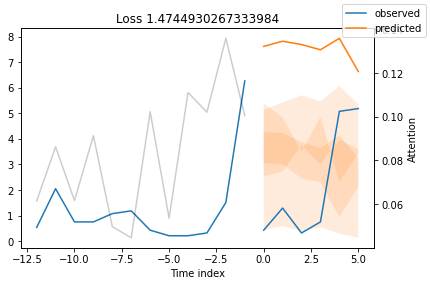

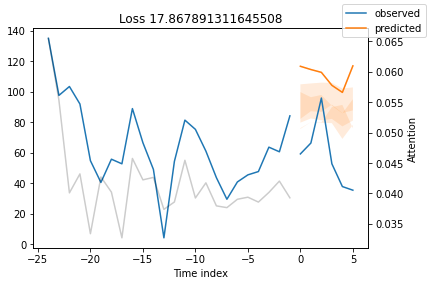

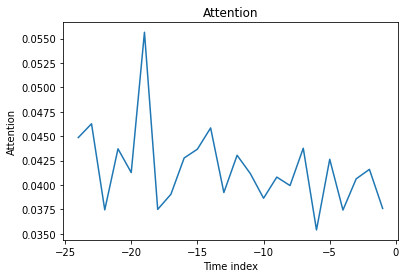

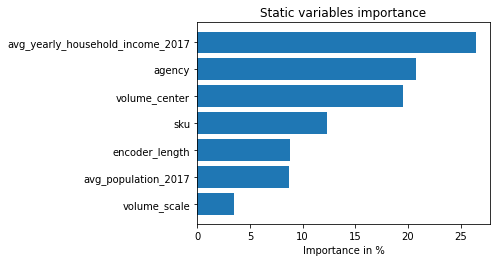

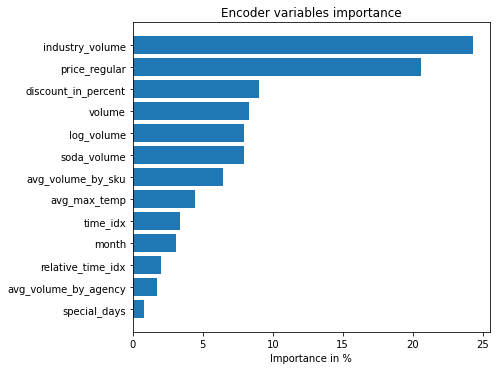

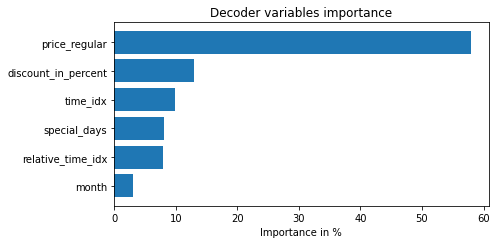

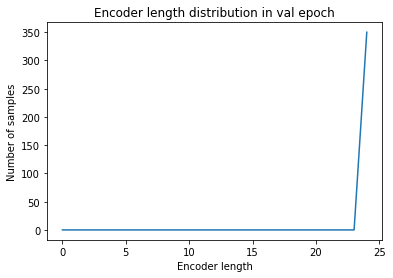

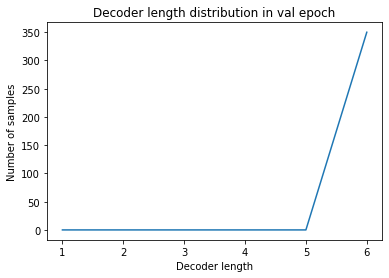

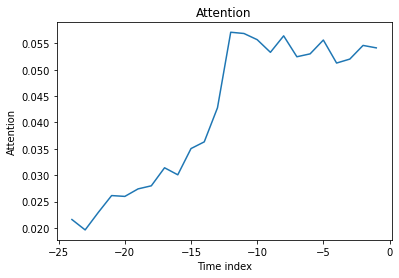

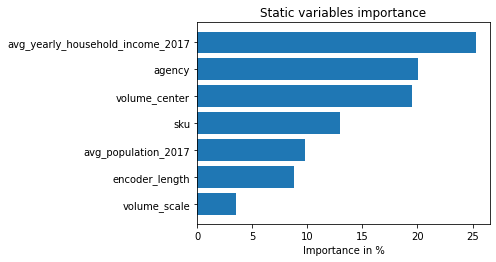

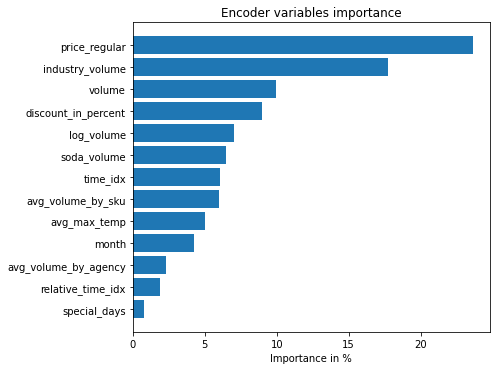

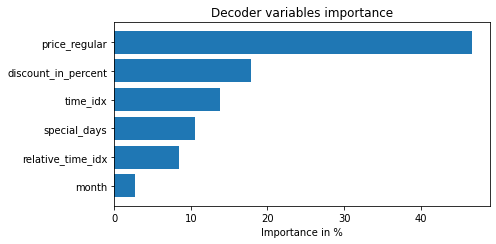

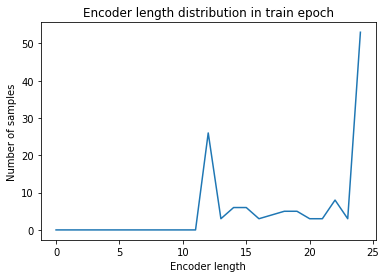

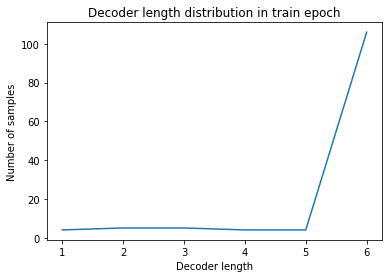

In [11]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

In [12]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(400.1118)

Baseline에 비해 성능이 꽤 좋지 못한 것을 확인할 수 있습니다.
아래에서 Hyperparameter Tuning을 통해 성능을 개선해보겠습니다.

# Hyperparameter Tuning

Pytorch-forecasting에서는 Hyperparameter Tuning을 [Optuna](https://optuna.org/)를 통해 제공합니다. 간단하게 optimize_hyperparameters() 함수를 통해 TFT의 Hyperparameter를 조정할 수 있습니다.

In [13]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=True  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2022-01-12 09:34:29,970] A new study created in memory with name: no-name-3a2851b1-b8a7-47e4-bbe3-9ceefb4b31a2
/home/junghwan/anaconda3/envs/pytorch1/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
/home/junghwan/anaconda3/envs/pytorch1/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:167: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU availabl

{'gradient_clip_val': 0.31010148936028237, 'hidden_size': 49, 'dropout': 0.195076051622603, 'hidden_continuous_size': 22, 'attention_head_size': 3, 'learning_rate': 0.0047863009232263845}


{'gradient_clip_val': 0.6882984132535679, 'hidden_size': 22, 'dropout': 0.20299481653421664, 'hidden_continuous_size': 15, 'attention_head_size': 2, 'learning_rate': 0.012022644346174132}

최종적으로 위와 같은 결과를 얻을 수 있었습니다.

최적화된 Hyperparameter를 바탕으로 best_tft 모델을 학습시킨 후 결과를 보겠습니다.

In [15]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.31010148936028237,
    limit_train_batches=30, 
    fast_dev_run=True,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


best_tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.0047863009232263845,
    hidden_size=49,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=3,
    dropout=0.195076051622603,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=22,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).


Number of parameters in network: 29.7k


In [16]:
# train best model
trainer.fit(
    best_tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K 
3  | prescalers                         | ModuleDict                      | 704   
4  | static_variable_selection          | VariableSelectionNetwork        | 19.2 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 44.0 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 15.6 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 9.9 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 9.9 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 9.9 

Epoch 0:  50%|▌| 1/2 [00:00<00:00,  3.67it/s, loss=152, v_num=, train_loss_step=
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]
Epoch 0: 100%|█| 2/2 [00:00<00:00,  3.70it/s, loss=152, v_num=, train_loss_step=
Epoch 0: 100%|█| 2/2 [00:00<00:00,  3.65it/s, loss=152, v_num=, train_loss_step=


In [17]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

# Evaluate Performance



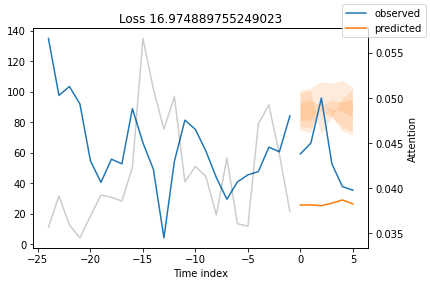

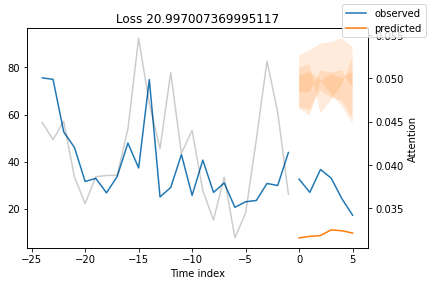

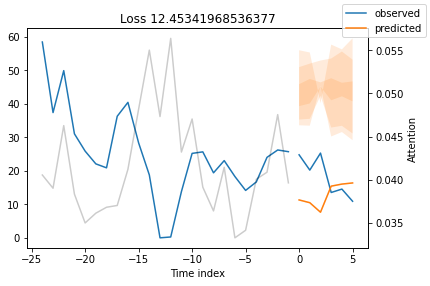

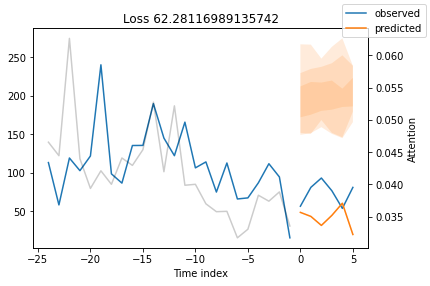

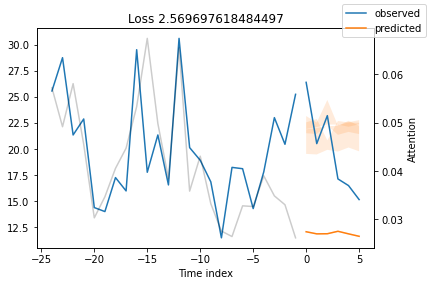

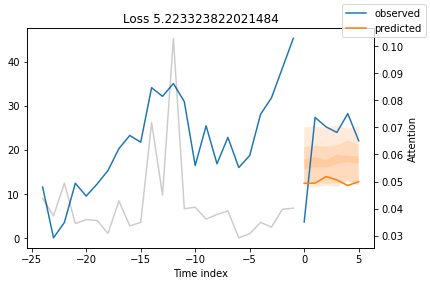

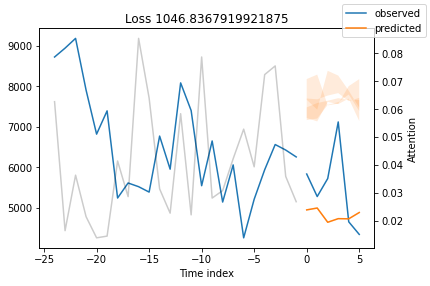

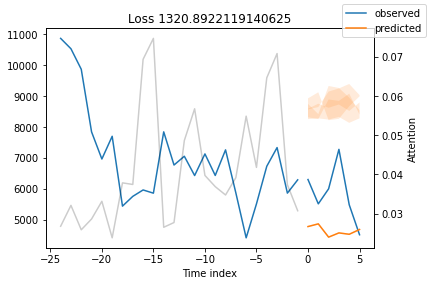

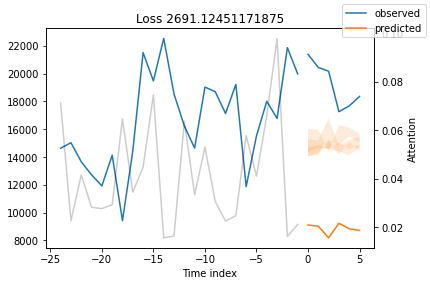

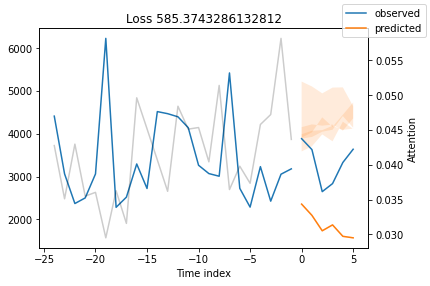

In [18]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

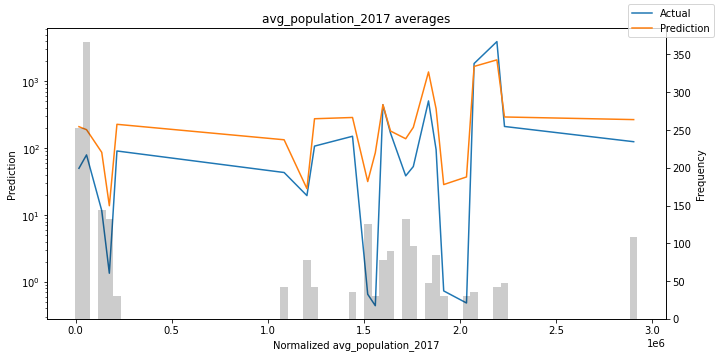

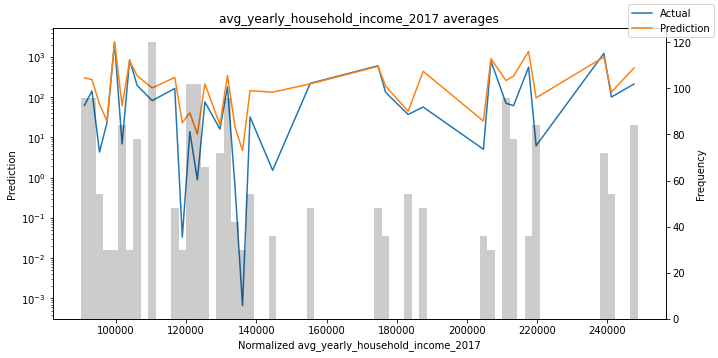

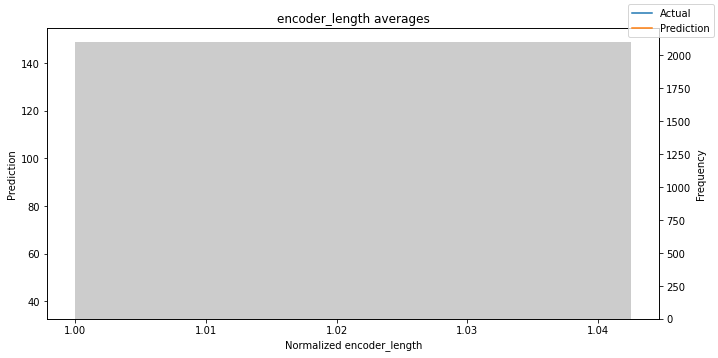

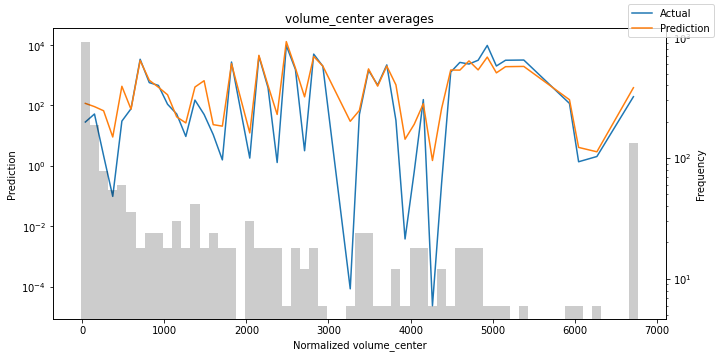

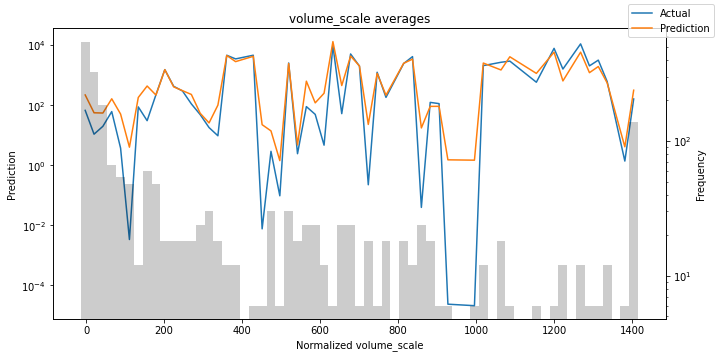

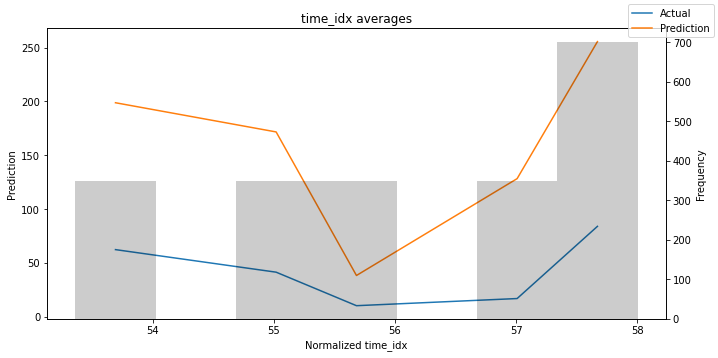

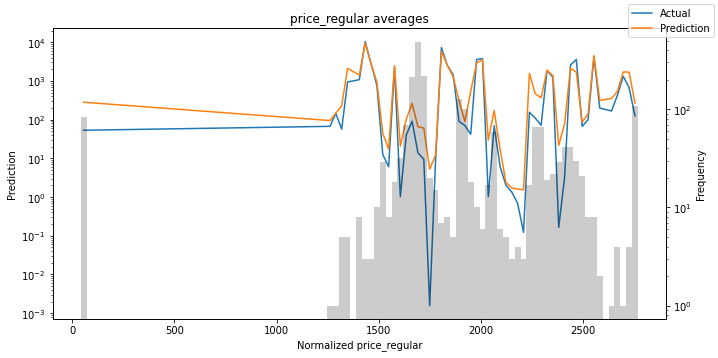

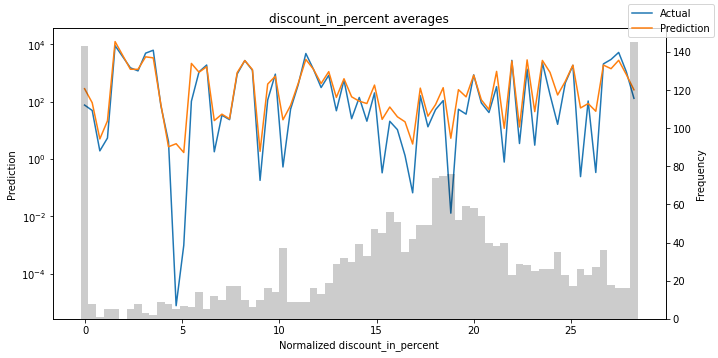

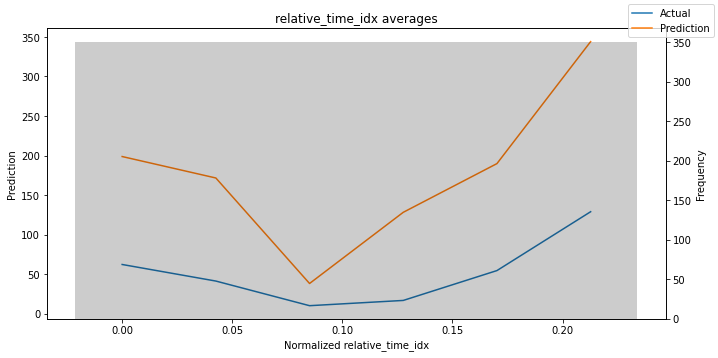

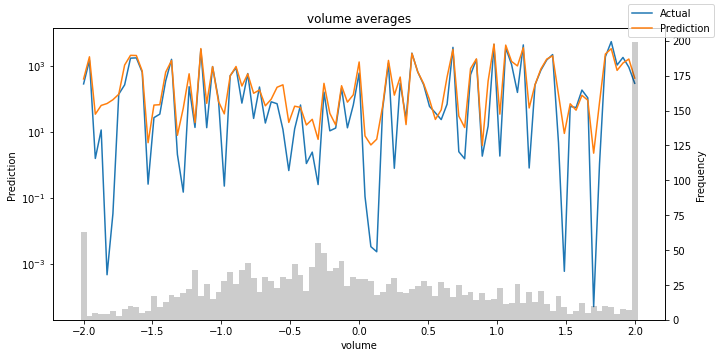

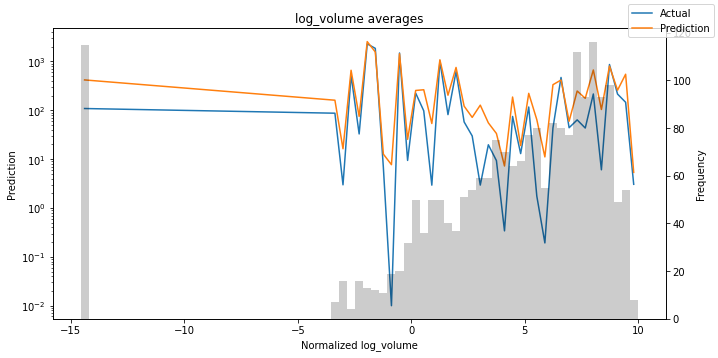

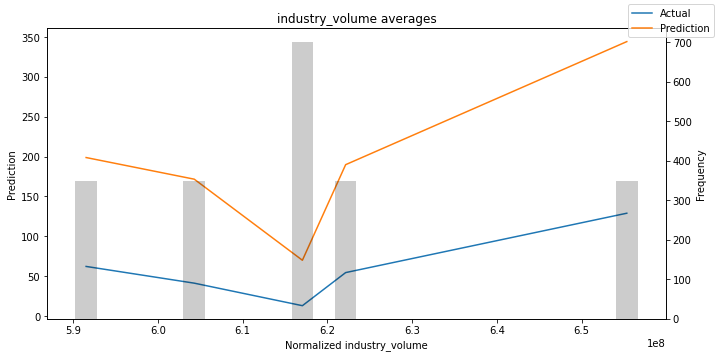

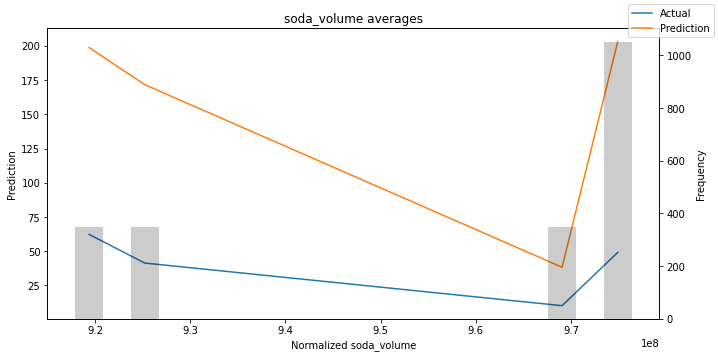

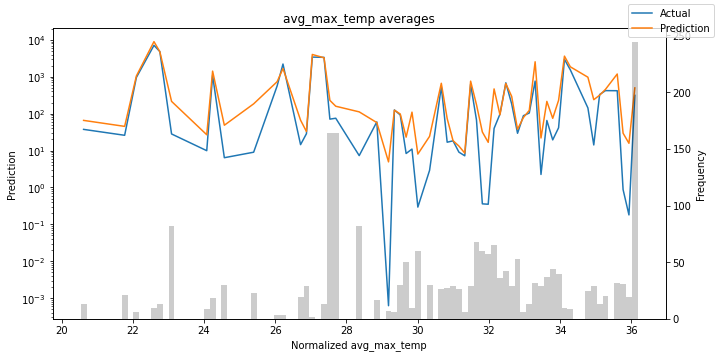

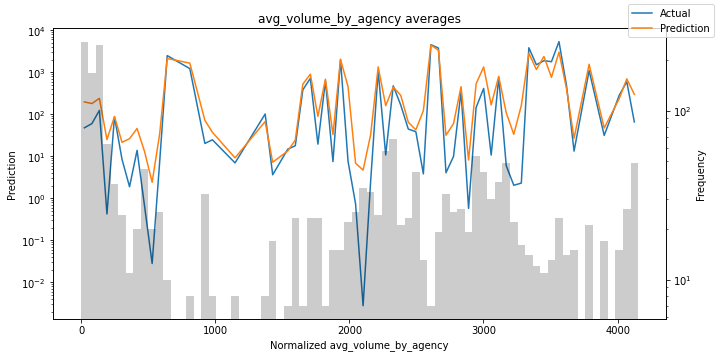

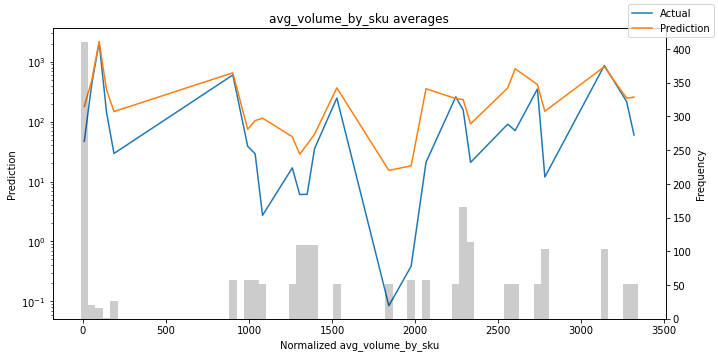

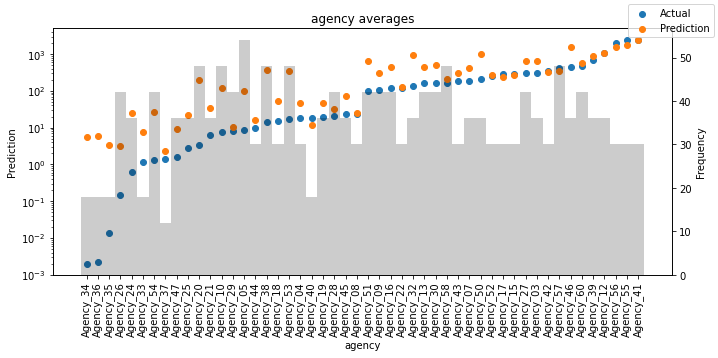

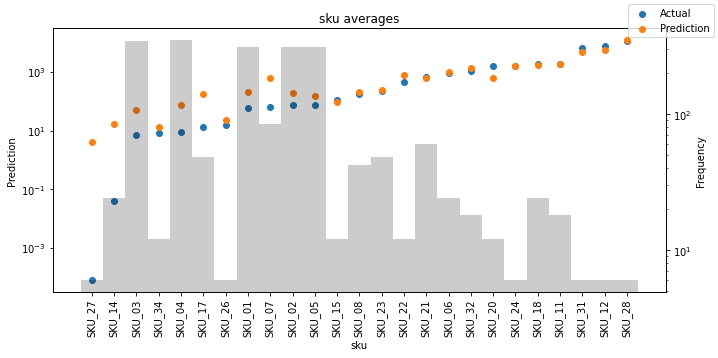

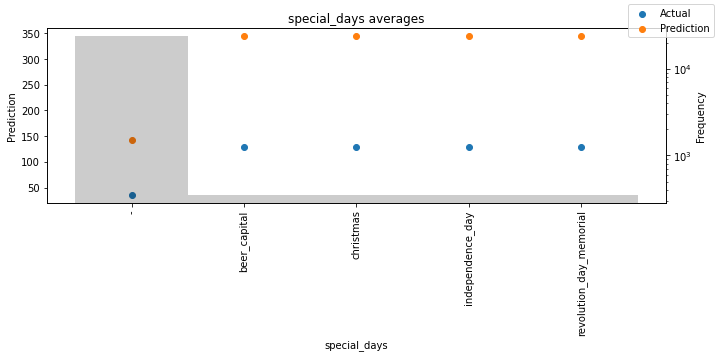

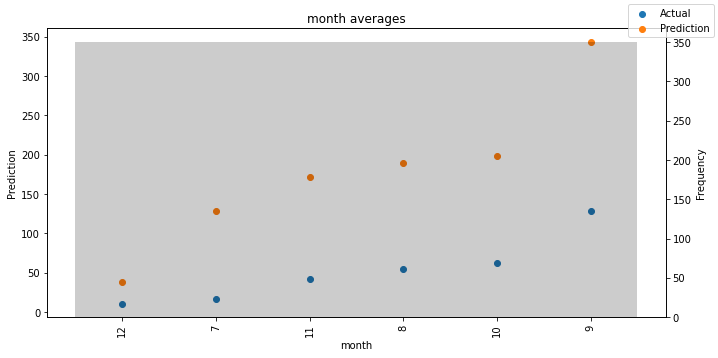

In [17]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

In [19]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
best_predictions = best_tft.predict(val_dataloader)
(actuals - best_predictions).abs().mean()

tensor(632.7969)

# XAI, Model Interpretation

Best_TFT 모델이 어떤 부분을 중요하게 보고 있는지 Attention 측면에서 Encoder Variable의 Feature Importance 측면에서 Decoder Variable의 Feature Importance 측면에서 확인할 수 있습니다.

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x270 with 1 Axes>,
 'encoder_variables': <Figure size 504x378 with 1 Axes>,
 'decoder_variables': <Figure size 504x252 with 1 Axes>}

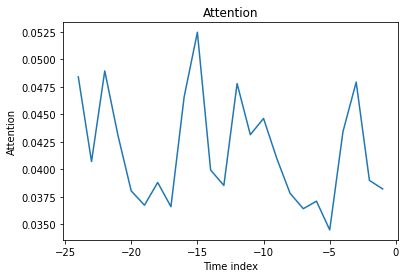

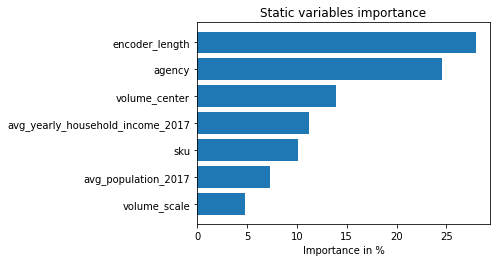

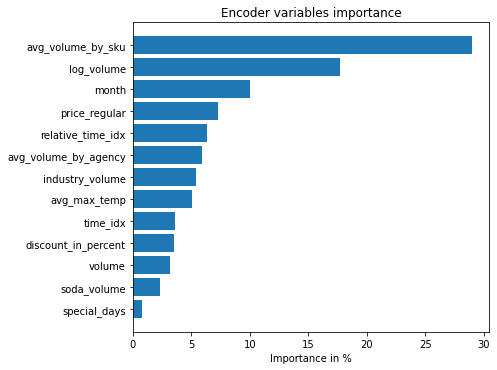

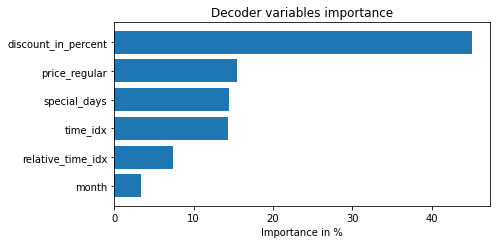

In [20]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

- Attention Layer의 경우 어느 정도의 주기성을 가지는 것으로 보입니다.
- Encoder Variables의 Feature Importance의 경우 avg_volume_by_sku와 log_volume 즉 Volume 데이터가 중요하게 고려되고 있음을 알 수 있습니다.
- Decoder Variables 중에서는 Discount_in_percent가 차지하는 비중이 압도적으로 높습니다.